In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Minmax Normalization
#### 1. Why?
  * If features are **not** on a similar scale, the distance calculation will be **dominated** by the features with larger numerical ranges.
  * **Example:** Imagine we have two features: `age` (ranging from 20 to 60) and `income` (ranging from 30,000 to 150,000). When calculating the distance between two data points, the difference in `income` (which can be tens of thousands) will vastly outweigh the difference in `age` (which is at most 40).
  * The `income` feature would essentially dictate who the "nearest" neighbors are, almost ignoring the `age` feature, even if `age` is relevant for the classification task. This undermines the core idea of finding neighbors that are similar across *all* characteristics.

#### 2. How?
Essentially, this transformation linearly shifts and scales the data so that the smallest value in the feature becomes 0, the largest value becomes 1, and all other values fall proportionally in between.
$$ X_{scaled} = \frac{X - X_{min}}{X_{max} - X_{min}} $$


In [2]:
def minmaxnormalization(X):
  X = np.array(X, dtype=float)
  min_vals = X.min(axis=0)
  max_vals = X.max(axis=0)
  return (X - min_vals) / (max_vals - min_vals)

data = [
    [150, 7.0, 1, 'Apple'],
    [120, 6.5, 0, 'Banana'],
    [180, 7.5, 2, 'Orange'],
    [155, 7.2, 1, 'Apple'],
    [110, 6.0, 0, 'Banana'],
    [190, 7.8, 2, 'Orange'],
    [145, 7.1, 1, 'Apple'],
    [115, 6.3, 0, 'Banana']
]

fruit_mapping = {'Apple': 0, "Banana": 1, "Orange": 2}
data = [[*row[:3], fruit_mapping[row[3]]] for row in data]

In [3]:
X = np.array([row[:3] for row in data], dtype=float)
y = np.array([row[3] for row in data], dtype=int)
X = minmaxnormalization(X)

### Logic behind ```train_test_split```
  * Lets say we have 10 rows
  * Choose a random permuation of numbers in $[1,10]$
  * Choose first $7$ of the resulted permutations and assign it as ```train_indices``` and rest $3$ as ```test_indices```


In [4]:
def train_test_split(X,y):
  len = y.shape[0]
  n_train = int(0.7*len)
  indices = np.random.permutation(len) #random permutation
  train_indices = indices[:n_train]
  test_indices = indices[n_train:]

  X_train = X[train_indices]
  X_test = X[test_indices]
  y_train = y[train_indices]
  y_test = y[test_indices]

  return X_train, X_test, y_train, y_test


In [5]:
train_test_split(X,y)

(array([[1.        , 1.        , 1.        ],
        [0.5       , 0.55555556, 0.5       ],
        [0.875     , 0.83333333, 1.        ],
        [0.5625    , 0.66666667, 0.5       ],
        [0.4375    , 0.61111111, 0.5       ]]),
 array([[0.125     , 0.27777778, 0.        ],
        [0.0625    , 0.16666667, 0.        ],
        [0.        , 0.        , 0.        ]]),
 array([2, 0, 2, 0, 0]),
 array([1, 1, 1]))

### `predict_one(self, x)` – Predict the class of a single input using KNN

  1. Calculate the distance of the new point with each point in train data
  2. Get the index of smallest $k$ distances
  3. Get the corresponding class for that $k$ distances
  4. Choose the most occuring class as your prediction(most common class in neighbour)



In [6]:
def Euclidean_distance(x, y):
  return np.sqrt(np.sum((x - y) ** 2))

class KNN :
  def __init__(self, k):
    self.k = k

  def fit(self, X,y):
    self.X_train = X
    self.y_train = y

  def predict_one(self, x):
    distances = []
    for point in self.X_train:
      distances.append(Euclidean_distance(point, x))
    k_indices = np.argsort(distances)[:self.k]
    k_labels = [self.y_train[i] for i in k_indices]

    labels, counts = np.unique(k_labels, return_counts=True)
    most_common = labels[np.argmax(counts)]
    return most_common

  def predict(self, X_test):
    return [self.predict_one(x) for x in X_test]

In [7]:
test_data = np.array([
    [118, 6.2, 0],  # Expected: Banana
    [160, 7.3, 1],  # Expected: Apple
    [185, 7.7, 2]   # Expected: Orange
])
test_data = minmaxnormalization(test_data)

knn_classifier = KNN(3)
knn_classifier.fit(X,y)
y_pred = np.array(knn_classifier.predict(test_data))
for i, pred in enumerate(y_pred):
  print(f"Test sample {i+1}: Predicted = {pred}")

Test sample 1: Predicted = 1
Test sample 2: Predicted = 0
Test sample 3: Predicted = 2


In [8]:
#Bonus: Simple accuracy checker
y_true = [1,0,2]
def accuracy(y_true, y_pred):
  return np.mean(np.array(y_true) == np.array(y_pred))

print('Accuracy: ',accuracy(y_true,y_pred))

Accuracy:  1.0


### Bonus Task: Visualize the decision boundaries in 2D using matplotlib

1. We have $3$ features but we have to visualize our decision tree in 2D.
2. I will use PCA to reduce its dimensionality

#### Implementation behind ```pca``` function

1. We will first center the data.
2. We will then form our covariance matrix
3. We will then find related eigenvectors(direction) and eigenvalue(strength in that direction)
4. High value of eigenvalue represents that it has a strong influence in respective eigenvector direction
4. We will then find direction with highest eigenvalues and project our data into that direction.
5. Below I am using matplotlib to visualize PCA and show a intuitive idea.

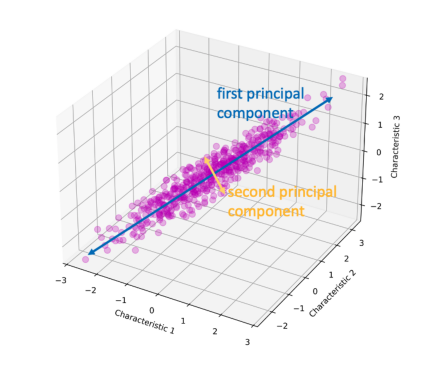

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("pca.png")
plt.imshow(img)
plt.axis("off")
plt.show()

In [9]:
def pca (X, n):
  X_meaned = X - np.mean(X, axis=0)
  cov_matrix = np.cov(X_meaned, rowvar=False)
  eigen_vals, eigen_vecs = np.linalg.eigh(cov_matrix)
  sorted_indices = np.argsort(eigen_vals)[::-1]
  top_components = eigen_vecs[:, sorted_indices[:n]]
  X_reduced = np.dot(X_meaned, top_components)

  return X_reduced

In [10]:
knn_pca = KNN(3)
X_pca = pca(X,2)
knn_pca.fit(X_pca, y)

#### Function to implement knn with reduced dimension using exisiting class and plotting it.

In [11]:
def plot_decision_boundary(knn, X, y_encoded, label_names, h=0.01):
    import matplotlib.pyplot as plt
    import numpy as np

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = np.array([knn.predict_one(point) for point in grid_points])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

    for class_index in np.unique(y_encoded):
        class_name = label_names[class_index]
        plt.scatter(X[y_encoded == class_index, 0],
                    X[y_encoded == class_index, 1],
                    label=class_name,
                    edgecolor='k')

    plt.title("KNN Decision Boundary (PCA 2D)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

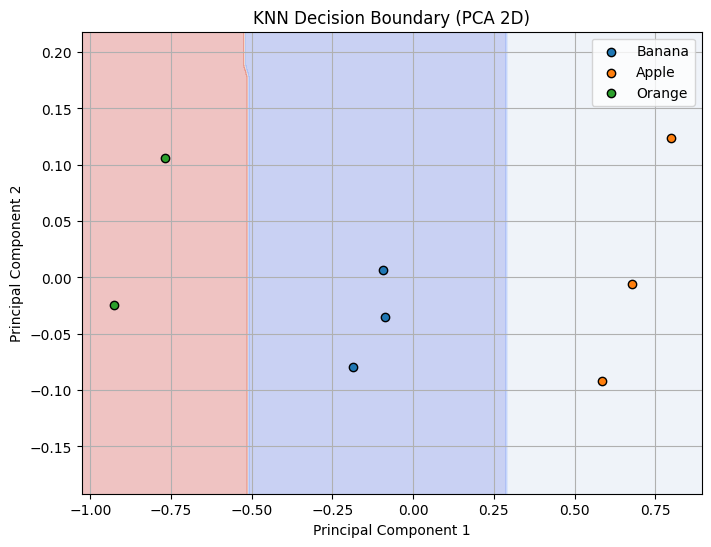

In [12]:
label_names = ['Banana', 'Apple', 'Orange']
plot_decision_boundary(knn_pca, X_pca, y, label_names)